In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from glob import glob
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = "1,2"

train_val_df = pd.read_csv("../../data/train_val.csv")
test_df = pd.read_csv("../../data/test.csv")

# Extract the paths and labels
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']
train_val_labels = train_val_df[disease_labels].values
test_labels = test_df[disease_labels].values

In [2]:
train_val_df['Paths'] = train_val_df['Paths'].apply(lambda x : x.split("../../../")[1])
test_df['Paths'] = test_df['Paths'].apply(lambda x : x.split("../../../")[1])

## random sample

In [3]:
len(train_val_df)

86523

In [4]:
# import random

# train_val_df = train_val_df.sample(frac=0.1, replace=True, random_state=1)
# test_df = test_df.sample(frac=0.1, replace=True, random_state=1)

# print("train_val_df length : ", len(train_val_df))
# print("test_df length : ", len(test_df))

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, labels, transform=None):
        self.dataframe = dataframe
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.dataframe.iloc[idx]['Paths'])
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_val_dataset = CustomDataset(train_val_df, train_val_labels, transform=transform)
test_dataset = CustomDataset(test_df, test_labels, transform=transform)

train_loader = DataLoader(train_val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
import torch.nn as nn
import torchvision.models as models

class ResNetModified(nn.Module):
    def __init__(self):
        super(ResNetModified, self).__init__()
        original_model = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 15),
            nn.Sigmoid()  # Sigmoid for multi-label classification
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetModified()

model = nn.DataParallel(model)
model = model.to(device)


/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# # 20시간 걸림 (1207m)

# criterion = nn.BCELoss()  # Binary Cross Entropy Loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 20

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, labels in tqdm(train_loader, desc=f"Train_loader Epoch: {epoch}"):
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

#     # Evaluate the model
#     model.eval()
#     all_labels = []
#     all_outputs = []
#     with torch.no_grad():
#         for images, labels in tqdm(test_loader, desc=f"Test_loader Epoch: {epoch}"):
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             all_labels.append(labels.cpu().numpy())
#             all_outputs.append(outputs.cpu().numpy())

#     all_labels = np.vstack(all_labels)
#     all_outputs = np.vstack(all_outputs)
#     all_outputs = (all_outputs > 0.5).astype(int)

#     accuracy = accuracy_score(all_labels, all_outputs)
#     roc_auc = roc_auc_score(all_labels, all_outputs)
#     f1 = f1_score(all_labels, all_outputs, average='micro')

#     print(f"Accuracy: {accuracy}, F1-Score: {f1}, Roc_Auc: {roc_auc}")


# root_save_path = "save"
# if not os.path.exists(root_save_path):
#     os.makedirs(root_save_path)
    
# model_save_path =os.path.join(root_save_path, "resnet_modified_bs64.pth")

# # Save the model
# torch.save(model.state_dict(), model_save_path)


Train_loader Epoch: 0:   0%|          | 0/1352 [00:00<?, ?it/s]

Train_loader Epoch: 0: 100%|██████████| 1352/1352 [3:12:47<00:00,  8.56s/it]  


Epoch 1, Loss: 0.1864662393982682


Test_loader Epoch: 0: 100%|██████████| 400/400 [48:49<00:00,  7.32s/it]


Accuracy: 0.18855245165071302, F1-Score: 0.21640961820525356, Roc_Auc: 0.5102334101464593


Train_loader Epoch: 1: 100%|██████████| 1352/1352 [2:52:54<00:00,  7.67s/it] 


Epoch 2, Loss: 0.1795437743490529


Test_loader Epoch: 1: 100%|██████████| 400/400 [51:04<00:00,  7.66s/it]


Accuracy: 0.23754639578042586, F1-Score: 0.2603118297310675, Roc_Auc: 0.5117887539366737


Train_loader Epoch: 2: 100%|██████████| 1352/1352 [2:25:38<00:00,  6.46s/it] 


Epoch 3, Loss: 0.17701797156467947


Test_loader Epoch: 2: 100%|██████████| 400/400 [49:55<00:00,  7.49s/it]


Accuracy: 0.19941394803672594, F1-Score: 0.23762591177492184, Roc_Auc: 0.5131715551835208


Train_loader Epoch: 3: 100%|██████████| 1352/1352 [2:41:31<00:00,  7.17s/it]  


Epoch 4, Loss: 0.17468743483100593


Test_loader Epoch: 3: 100%|██████████| 400/400 [49:14<00:00,  7.39s/it] 


Accuracy: 0.2049619066223872, F1-Score: 0.252758790631897, Roc_Auc: 0.5158051638546933


Train_loader Epoch: 4: 100%|██████████| 1352/1352 [2:33:52<00:00,  6.83s/it] 


Epoch 5, Loss: 0.17211368795726778


Test_loader Epoch: 4: 100%|██████████| 400/400 [49:43<00:00,  7.46s/it]


Accuracy: 0.19113108028911896, F1-Score: 0.2594875258558825, Roc_Auc: 0.519484794853683


Train_loader Epoch: 5: 100%|██████████| 1352/1352 [2:56:25<00:00,  7.83s/it] 


Epoch 6, Loss: 0.16921996842166023


Test_loader Epoch: 5: 100%|██████████| 400/400 [49:13<00:00,  7.38s/it]


Accuracy: 0.1762453604219574, F1-Score: 0.25024244122147277, Roc_Auc: 0.5201872996386017


Train_loader Epoch: 6: 100%|██████████| 1352/1352 [2:34:14<00:00,  6.85s/it] 


Epoch 7, Loss: 0.16692844544642071


Test_loader Epoch: 6: 100%|██████████| 400/400 [47:31<00:00,  7.13s/it]


Accuracy: 0.20257862863840595, F1-Score: 0.27640374331550804, Roc_Auc: 0.5232217651222012


Train_loader Epoch: 7: 100%|██████████| 1352/1352 [2:25:23<00:00,  6.45s/it] 


Epoch 8, Loss: 0.1648012763991423


Test_loader Epoch: 7: 100%|██████████| 400/400 [49:15<00:00,  7.39s/it]  


Accuracy: 0.16346942762258254, F1-Score: 0.21444710409163106, Roc_Auc: 0.5160808757076132


Train_loader Epoch: 8: 100%|██████████| 1352/1352 [1:48:40<00:00,  4.82s/it]


Epoch 9, Loss: 0.1624061978482724


Test_loader Epoch: 8: 100%|██████████| 400/400 [44:52<00:00,  6.73s/it]


Accuracy: 0.2627466302012112, F1-Score: 0.3056314926189174, Roc_Auc: 0.5205124007047348


Train_loader Epoch: 9: 100%|██████████| 1352/1352 [2:15:14<00:00,  6.00s/it] 


Epoch 10, Loss: 0.1600727126685649


Test_loader Epoch: 9: 100%|██████████| 400/400 [45:17<00:00,  6.79s/it]


Accuracy: 0.23797616722016018, F1-Score: 0.30213027854434277, Roc_Auc: 0.5253189162261305


Train_loader Epoch: 10: 100%|██████████| 1352/1352 [2:21:59<00:00,  6.30s/it]  


Epoch 11, Loss: 0.15701818948380164


Test_loader Epoch: 10: 100%|██████████| 400/400 [1:01:01<00:00,  9.15s/it]


Accuracy: 0.24360226606759133, F1-Score: 0.3083265934152644, Roc_Auc: 0.5276421675482641


Train_loader Epoch: 11: 100%|██████████| 1352/1352 [1:42:45<00:00,  4.56s/it]


Epoch 12, Loss: 0.15367100081963123


Test_loader Epoch: 11: 100%|██████████| 400/400 [15:04<00:00,  2.26s/it]


Accuracy: 0.26118382496581366, F1-Score: 0.3413557888543639, Roc_Auc: 0.5341079918422865


Train_loader Epoch: 12: 100%|██████████| 1352/1352 [31:58<00:00,  1.42s/it]


Epoch 13, Loss: 0.1489294659147954


Test_loader Epoch: 12: 100%|██████████| 400/400 [09:15<00:00,  1.39s/it]


Accuracy: 0.16491502246532525, F1-Score: 0.27198446727611036, Roc_Auc: 0.5327536899591357


Train_loader Epoch: 13: 100%|██████████| 1352/1352 [24:30<00:00,  1.09s/it]


Epoch 14, Loss: 0.14287556181028044


Test_loader Epoch: 13: 100%|██████████| 400/400 [07:06<00:00,  1.07s/it]


Accuracy: 0.214612228950967, F1-Score: 0.33632350344340456, Roc_Auc: 0.5405156004238274


Train_loader Epoch: 14: 100%|██████████| 1352/1352 [24:28<00:00,  1.09s/it]


Epoch 15, Loss: 0.1350233705560043


Test_loader Epoch: 14: 100%|██████████| 400/400 [06:52<00:00,  1.03s/it]


Accuracy: 0.21211174057433094, F1-Score: 0.3021796317173995, Roc_Auc: 0.5309352590028567


Train_loader Epoch: 15: 100%|██████████| 1352/1352 [24:29<00:00,  1.09s/it]


Epoch 16, Loss: 0.12553472197531948


Test_loader Epoch: 15: 100%|██████████| 400/400 [06:52<00:00,  1.03s/it]


Accuracy: 0.2137136159406134, F1-Score: 0.3143674157715291, Roc_Auc: 0.5367247688308943


Train_loader Epoch: 16: 100%|██████████| 1352/1352 [24:32<00:00,  1.09s/it]


Epoch 17, Loss: 0.11496904713360692


Test_loader Epoch: 16: 100%|██████████| 400/400 [06:55<00:00,  1.04s/it]


Accuracy: 0.19109201015823404, F1-Score: 0.28672516275120297, Roc_Auc: 0.5414712250519317


Train_loader Epoch: 17: 100%|██████████| 1352/1352 [24:30<00:00,  1.09s/it]


Epoch 18, Loss: 0.10375383378904776


Test_loader Epoch: 17: 100%|██████████| 400/400 [07:18<00:00,  1.10s/it]


Accuracy: 0.20441492478999804, F1-Score: 0.31597435372757654, Roc_Auc: 0.5435653670294397


Train_loader Epoch: 18: 100%|██████████| 1352/1352 [24:32<00:00,  1.09s/it]


Epoch 19, Loss: 0.09310145762379794


Test_loader Epoch: 18: 100%|██████████| 400/400 [06:53<00:00,  1.03s/it]


Accuracy: 0.2364524321156476, F1-Score: 0.3330173259235044, Roc_Auc: 0.5407155171867369


Train_loader Epoch: 19: 100%|██████████| 1352/1352 [24:31<00:00,  1.09s/it]


Epoch 20, Loss: 0.08416365419057083


Test_loader Epoch: 19: 100%|██████████| 400/400 [07:00<00:00,  1.05s/it]


Accuracy: 0.21707364719671812, F1-Score: 0.3271761093344789, Roc_Auc: 0.5429087047504483


In [8]:
model_weight_path = torch.load("save/resnet_modified_bs64.pth")
model.load_state_dict(model_weight_path)

<All keys matched successfully>

In [9]:
# 20분 걸림 (20m)
def evaluate_and_save_results(model, test_loader, threshold=0.5):
    model.eval()
    all_labels = []
    all_outputs = []
    all_filenames = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Test Loader"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
            all_filenames.extend(test_loader.dataset.dataframe.iloc[:len(images)]['Paths'].tolist())

    all_labels = np.vstack(all_labels)
    all_outputs = np.vstack(all_outputs)
    binary_outputs = (all_outputs > threshold).astype(int)

    results_df = pd.DataFrame({
        'filename': all_filenames,
        'true_labels': list(all_labels),
        'predicted_labels': list(binary_outputs),
        'predicted_probabilities': list(all_outputs)
    })

    results_df.to_csv('evaluation_results.csv', index=False)

    accuracy = accuracy_score(all_labels, binary_outputs)
    # precision = precision_score(all_labels, binary_outputs, average='micro')
    # recall = roc_auc_score(all_labels, binary_outputs)
    f1 = f1_score(all_labels, binary_outputs, average='micro')
    roc_auc_macro = roc_auc_score(all_labels, all_outputs, average='macro')

    print(f"Accuracy: {accuracy}, F1-Score: {f1}, ROC_AUC:  {roc_auc_macro}")
    
    return all_labels, all_outputs, binary_outputs

# Evaluate the model and save results
all_labels, all_outputs, binary_outputs = evaluate_and_save_results(model, test_loader, threshold=0.5)


Test Loader: 100%|██████████| 400/400 [10:59<00:00,  1.65s/it]


Accuracy: 0.21707364719671812, F1-Score: 0.3271761093344789, ROC_AUC:  0.6861211236656257


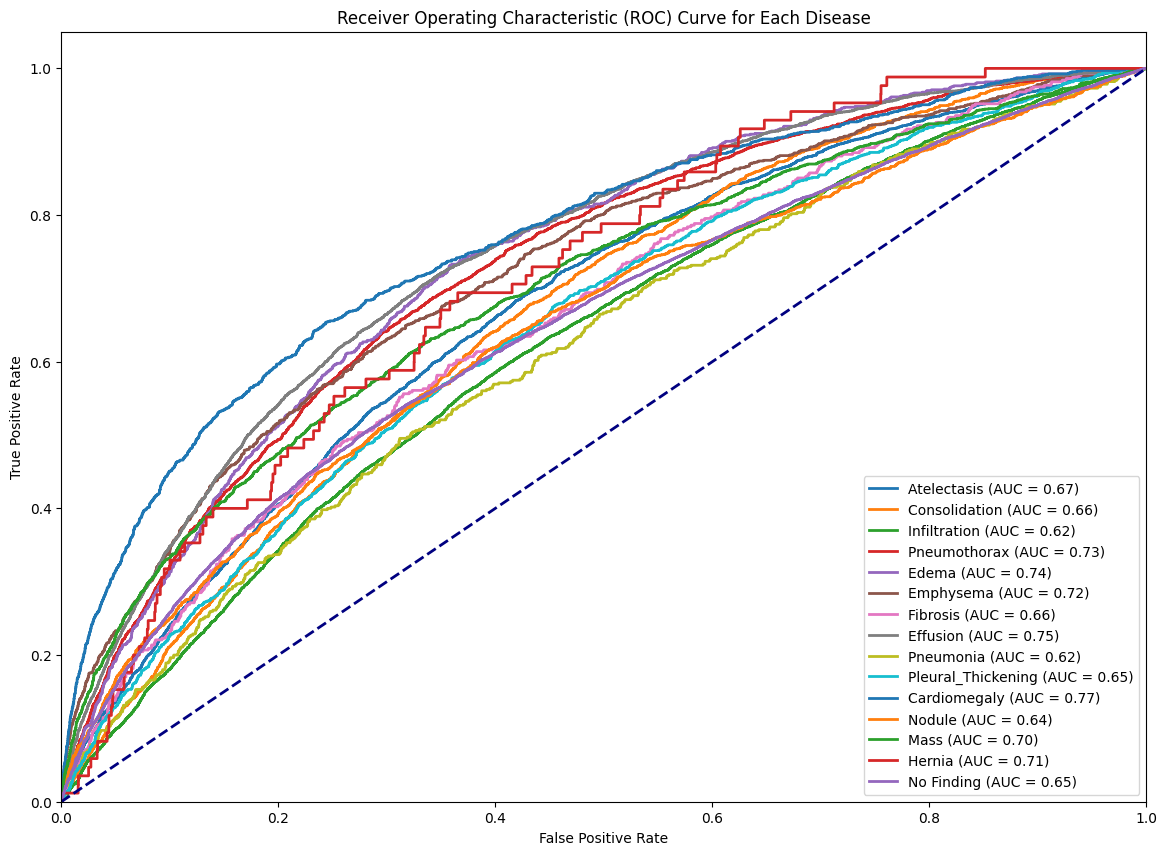

Atelectasis - ROC AUC Score: 0.6744
Consolidation - ROC AUC Score: 0.6638
Infiltration - ROC AUC Score: 0.6222
Pneumothorax - ROC AUC Score: 0.7291
Edema - ROC AUC Score: 0.7388
Emphysema - ROC AUC Score: 0.7238
Fibrosis - ROC AUC Score: 0.6597
Effusion - ROC AUC Score: 0.7458
Pneumonia - ROC AUC Score: 0.6174
Pleural_Thickening - ROC AUC Score: 0.6479
Cardiomegaly - ROC AUC Score: 0.7664
Nodule - ROC AUC Score: 0.6449
Mass - ROC AUC Score: 0.6962
Hernia - ROC AUC Score: 0.7145
No Finding - ROC AUC Score: 0.6469
Overall Accuracy: 0.7786


In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


# Plot ROC curve for each class
plt.figure(figsize=(14, 10))
for i, disease in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(all_labels[:, i], all_outputs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{disease} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Disease')
plt.legend(loc='lower right')
plt.show()

# Print ROC AUC scores for each class
for i, disease in enumerate(disease_labels):
    roc_auc_label = roc_auc_score(all_labels[:, i], all_outputs[:, i])
    print(f'{disease} - ROC AUC Score: {roc_auc_label:.4f}')
    
# Calculate overall accuracy
overall_accuracy = roc_auc_score(all_labels.reshape(-1), all_outputs.reshape(-1))
print(f'Overall Accuracy: {overall_accuracy:.4f}')    


## 개별 스코어 값

In [11]:
# 정확도 및 F1 스코어 계산
accuracy = accuracy_score(all_labels, binary_outputs)
f1_micro = f1_score(all_labels, binary_outputs, average='micro')
f1_macro = f1_score(all_labels, binary_outputs, average='macro')

for idx in range(all_labels.shape[1]):
    accuracy_label = accuracy_score(all_labels[:, idx], binary_outputs[:, idx])
    f1_score_label = f1_score(all_labels[:, idx], binary_outputs[:, idx])
    print(f"Class {idx} - Accuracy: {accuracy_label}, F1 score: {f1_score_label}")

Class 0 - Accuracy: 0.796171127173276, F1 score: 0.26902059688944935
Class 1 - Accuracy: 0.9252197694862277, F1 score: 0.025458248472505093
Class 2 - Accuracy: 0.6913459660089861, F1 score: 0.34483330568916903
Class 3 - Accuracy: 0.8934166829458878, F1 score: 0.07147719537100068
Class 4 - Accuracy: 0.9615159210783356, F1 score: 0.046466602129719266
Class 5 - Accuracy: 0.9565930845868333, F1 score: 0.060862214708368556
Class 6 - Accuracy: 0.9826137917562023, F1 score: 0.0
Class 7 - Accuracy: 0.7780035163117797, F1 score: 0.4272177419354839
Class 8 - Accuracy: 0.9783551474897441, F1 score: 0.0035971223021582736
Class 9 - Accuracy: 0.9512014065247119, F1 score: 0.023455824863174355
Class 10 - Accuracy: 0.9478804453994921, F1 score: 0.23421354764638347
Class 11 - Accuracy: 0.9342058995897636, F1 score: 0.05711086226203808
Class 12 - Accuracy: 0.9065833170541121, F1 score: 0.22646392753154318
Class 13 - Accuracy: 0.9966790388747803, F1 score: 0.0
Class 14 - Accuracy: 0.6479781207267045, F1 

# 각 loss 계산 결과

In [12]:
all_labels, all_outputs
# Cell 1: Import necessary libraries
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, coverage_error, label_ranking_loss, average_precision_score

# Assuming 'all_labels' and 'ensemble_preds' are already defined and have compatible shapes
# Convert ensemble probabilities to class predictions using a threshold (e.g., 0.5)
threshold = 0.5
all_outputs_pred = binary_outputs

# Define the disease labels
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

# Calculate accuracy for each class
print("Accuracy for each class:")
for i, disease in enumerate(disease_labels):
    accuracy_class = accuracy_score(all_labels[:, i], all_outputs_pred[:, i])
    print(f'{disease} - Accuracy: {accuracy_class:.4f}')

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels.reshape(-1), all_outputs_pred.reshape(-1))
print(f'Overall Accuracy: {overall_accuracy:.4f}')

print("all_labels.shape : ", all_labels.shape)

# Calculate overall accuracy before reshape
overall_accuracy_bf_reshape = accuracy_score(all_labels, all_outputs_pred)
print(f'Overall Accuracy before reshape: {overall_accuracy_bf_reshape:.4f}')


Accuracy for each class:
Atelectasis - Accuracy: 0.7962
Consolidation - Accuracy: 0.9252
Infiltration - Accuracy: 0.6913


Pneumothorax - Accuracy: 0.8934
Edema - Accuracy: 0.9615
Emphysema - Accuracy: 0.9566
Fibrosis - Accuracy: 0.9826
Effusion - Accuracy: 0.7780
Pneumonia - Accuracy: 0.9784
Pleural_Thickening - Accuracy: 0.9512
Cardiomegaly - Accuracy: 0.9479
Nodule - Accuracy: 0.9342
Mass - Accuracy: 0.9066
Hernia - Accuracy: 0.9967
No Finding - Accuracy: 0.6480
Overall Accuracy: 0.8899
all_labels.shape :  (25595, 15)
Overall Accuracy before reshape: 0.2171


In [13]:
# Cell 2: Calculate Hamming Loss
hamming_loss_value = hamming_loss(all_labels, all_outputs_pred)
print(f'Hamming Loss: {hamming_loss_value:.4f}')


Hamming Loss: 0.1101


In [14]:
# Cell 3: Calculate Ranking Loss
ranking_loss_value = label_ranking_loss(all_labels, all_outputs_pred)
print(f'Ranking Loss: {ranking_loss_value:.4f}')


Ranking Loss: 0.6980


In [15]:
# Cell 4: Calculate Multilabel Accuracy
accuracy_each_class = []

# Calculate accuracy for each class
for i, disease in enumerate(disease_labels):
    accuracy_each_class.append(accuracy_score(all_labels[:, i], all_outputs_pred[:, i]))

multilabel_accuracy = np.average(accuracy_each_class)
print(f'Multilabel Accuracy: {multilabel_accuracy:.4f}')


Multilabel Accuracy: 0.8899


In [16]:
# Cell 5: Calculate Multilabel Coverage
multilabel_coverage = coverage_error(all_labels, all_outputs_pred)
print(f'Multilabel Coverage: {multilabel_coverage:.4f}')


Multilabel Coverage: 11.5035


In [17]:
# Cell 6: Calculate One Error
def one_error(y_true, y_pred):
    n_samples = y_true.shape[0]
    one_error_count = 0
    for i in range(n_samples):
        top_pred_idx = np.argmax(y_pred[i])
        if y_true[i, top_pred_idx] == 0:
            one_error_count += 1
    return one_error_count / n_samples

one_error_value = one_error(all_labels, all_outputs_pred)
print(f'One Error: {one_error_value:.4f}')

One Error: 0.6446


In [18]:
# Cell 7: Calculate Subset Accuracy
subset_accuracy = accuracy_score(all_labels, all_outputs_pred, normalize=True)
print(f'Subset Accuracy: {subset_accuracy:.4f}')


Subset Accuracy: 0.2171


In [19]:
# Cell 8: Calculate Macro F1 Score
macro_f1_score = f1_score(all_labels, all_outputs_pred, average='macro')
print(f'Macro F1 Score: {macro_f1_score:.4f}')


Macro F1 Score: 0.1520


In [20]:
# Cell 9: Calculate Micro F1 Score
micro_f1_score = f1_score(all_labels, all_outputs_pred, average='micro')
print(f'Micro F1 Score: {micro_f1_score:.4f}')


Micro F1 Score: 0.3272


In [21]:
# Record each class accuracy
columns = disease_labels

for i,v in enumerate(accuracy_each_class):
    accuracy_each_class[i] = f"{v:.4f}"

result = pd.DataFrame([accuracy_each_class], columns=columns)
result.to_csv("each_class_accuracy.csv", index=False)

In [22]:
# Record over all loss
columns = [
    "Hamming Loss",
    "Ranking Loss",
    "Multilabel Accuracy",
    "Multilabel Coverage",
    "One Error",
    "Subset Accuracy",
    "Macro F1 score",
    "Micro F1 score"
]

over_score=[]

over_score.append(f"{hamming_loss_value:.4f}")
over_score.append(f"{ranking_loss_value:.4f}")
over_score.append(f"{multilabel_accuracy:.4f}")
over_score.append(f"{multilabel_coverage:.4f}")
over_score.append(f"{one_error_value:.4f}")
over_score.append(f"{subset_accuracy:.4f}")
over_score.append(f"{macro_f1_score:.4f}")
over_score.append(f"{micro_f1_score:.4f}")

result = pd.DataFrame([over_score], columns=columns)
result.to_csv("overall_score.csv", index=False)